In [1]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = 'fruits_dataset'
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 9124


In [5]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [6]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Avocado (2)


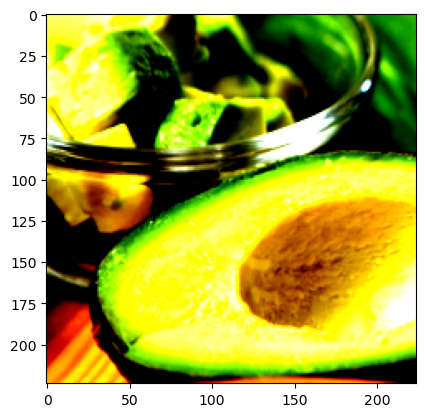

In [7]:
show_image(*dataset[200])

In [8]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [9]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(7756, 456, 912)

In [10]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


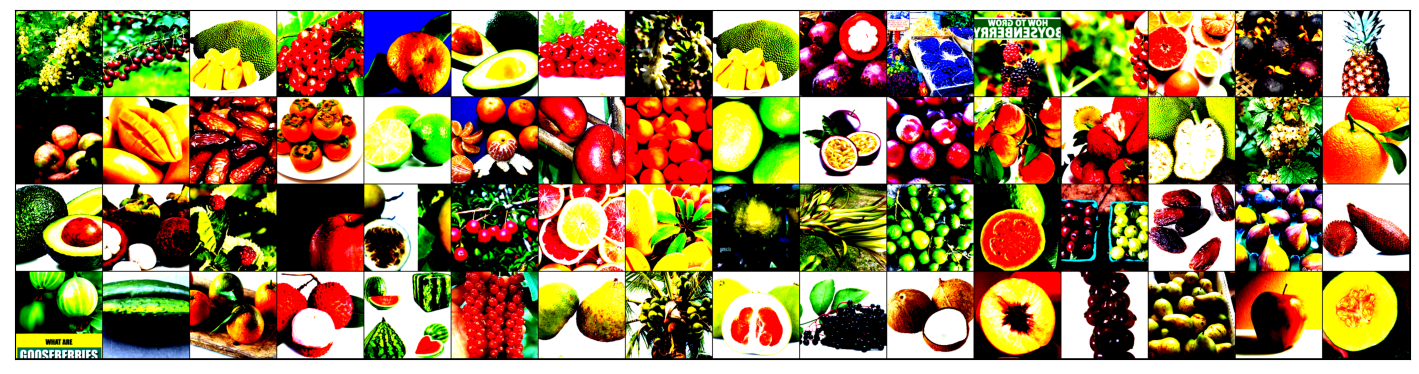

In [11]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [12]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
input_size = 3*224*224
output_size = 55

In [16]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
# Convolutional Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.conv11 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
        )
        
        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384 * 7 * 7, 4096),
            nn.Dropout(0.5),  # Dropout Layer
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.Dropout(0.4),  # Dropout Layer
        )
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 120),
            nn.Dropout(0.5),  # Dropout Layer
        )
        self.fc4 = nn.Linear(120, num_classes)  # Output layer

    def forward(self, x):
        x = self.pool(self.conv3(self.conv2(self.conv1(x))))
        x = self.pool(self.conv5(self.conv4(x)))
        x = self.pool(self.conv7(self.conv6(x)))
        x = self.pool(self.conv10(self.conv9(self.conv8(x))))
        x = self.pool(self.conv11(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        return x


In [17]:
# Model print
num_classes = 55
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [18]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 55])
out[0]: tensor([ 0.1625,  0.1168, -0.0085, -0.1462, -0.2034,  0.2385, -0.1019, -0.0242,
         0.2900,  0.3743,  0.2668, -0.1079, -0.4530, -0.0712,  0.3196,  0.0711,
         0.3442, -0.3311, -0.1694, -0.2197,  0.2377,  0.4680,  0.2926, -0.2538,
         0.2366,  0.1293, -0.3444,  0.0302,  0.4060, -0.0516,  0.0447,  0.1618,
        -0.1125, -0.0679, -0.0657,  0.4253, -0.1078,  0.0343,  0.2457,  0.1900,
        -0.1725, -0.6195, -0.5524, -0.2536,  0.1690, -0.4119, -0.6418,  0.2534,
         0.1642, -0.1261,  0.0765, -0.2492,  0.3296, -0.2763, -0.2050],
       grad_fn=<SelectBackward0>)


In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5),

In [20]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_period, gamma=lr_drop_factor)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        scheduler.step()  # Adjust learning rate
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [21]:
model = to_device(model, device)

In [22]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 4.008342742919922, 'val_acc': 0.060546875}]

In [29]:
print(test_size)
num_epochs = 110
optimizer = torch.optim.SGD
momentum = 0.90
lr = 0.01
lr_drop_period = 50
lr_drop_factor = 0.2
epochs = 110
l2_reg = 0.0005

912


In [24]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, optimizer)

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.7819, val_loss: 3.5580, val_acc: 0.2246


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.3476, val_loss: 3.3149, val_acc: 0.3086


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.1170, val_loss: 3.2951, val_acc: 0.3203


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.9504, val_loss: 3.0882, val_acc: 0.3867


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.8418, val_loss: 3.4057, val_acc: 0.3379


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.7134, val_loss: 2.9705, val_acc: 0.4258


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.6301, val_loss: 3.7258, val_acc: 0.3281


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.5513, val_loss: 4.9987, val_acc: 0.2363


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.4603, val_loss: 3.1808, val_acc: 0.4277


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.3541, val_loss: 2.8222, val_acc: 0.4375


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [10], train_loss: 2.3198, val_loss: 3.9728, val_acc: 0.4434


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [11], train_loss: 2.2394, val_loss: 2.4650, val_acc: 0.5645


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [12], train_loss: 2.1939, val_loss: 2.7855, val_acc: 0.5215


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [13], train_loss: 2.1123, val_loss: 4.3408, val_acc: 0.4062


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [14], train_loss: 2.0841, val_loss: 3.3495, val_acc: 0.3984


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.9823, val_loss: 4.5146, val_acc: 0.3730


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.9424, val_loss: 2.4630, val_acc: 0.5879


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.8799, val_loss: 2.9492, val_acc: 0.5293


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.8331, val_loss: 4.4964, val_acc: 0.3809


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [19], train_loss: 1.7717, val_loss: 3.6837, val_acc: 0.5137


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [20], train_loss: 1.7242, val_loss: 2.9053, val_acc: 0.5371


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [21], train_loss: 1.6826, val_loss: 3.4108, val_acc: 0.4531


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [22], train_loss: 1.6504, val_loss: 3.0554, val_acc: 0.5918


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [23], train_loss: 1.5935, val_loss: 3.1545, val_acc: 0.5039


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [24], train_loss: 1.5878, val_loss: 4.9981, val_acc: 0.4570


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [25], train_loss: 1.5175, val_loss: 3.3984, val_acc: 0.4805


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [26], train_loss: 1.4834, val_loss: 3.0567, val_acc: 0.5371


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [27], train_loss: 1.4433, val_loss: 4.2905, val_acc: 0.4160


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [28], train_loss: 1.3868, val_loss: 3.8885, val_acc: 0.5039


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [29], train_loss: 1.3644, val_loss: 2.8002, val_acc: 0.6094


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [30], train_loss: 1.3055, val_loss: 2.7645, val_acc: 0.6621


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [31], train_loss: 1.2658, val_loss: 3.9462, val_acc: 0.5195


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [32], train_loss: 1.2511, val_loss: 2.6891, val_acc: 0.6426


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [33], train_loss: 1.1896, val_loss: 3.0170, val_acc: 0.5488


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [34], train_loss: 1.1634, val_loss: 2.4304, val_acc: 0.6719


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [35], train_loss: 1.1132, val_loss: 6.8531, val_acc: 0.3398


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [36], train_loss: 1.1143, val_loss: 2.1788, val_acc: 0.7012


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [37], train_loss: 1.0545, val_loss: 7.7942, val_acc: 0.2520


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [38], train_loss: 1.0494, val_loss: 4.3086, val_acc: 0.5469


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [39], train_loss: 1.0022, val_loss: 5.9700, val_acc: 0.4082


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.9832, val_loss: 11.3664, val_acc: 0.3027


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.9582, val_loss: 3.3035, val_acc: 0.5801


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.8616, val_loss: 2.6205, val_acc: 0.7227


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.8638, val_loss: 2.1616, val_acc: 0.7246


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.8219, val_loss: 2.8900, val_acc: 0.6133


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.8231, val_loss: 9.4941, val_acc: 0.3867


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.8073, val_loss: 2.7881, val_acc: 0.6719


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.7271, val_loss: 3.7068, val_acc: 0.5508


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.7553, val_loss: 8.6942, val_acc: 0.3945


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.7187, val_loss: 4.3274, val_acc: 0.5547


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.4950, val_loss: 1.5413, val_acc: 0.8125


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.4082, val_loss: 1.4541, val_acc: 0.8301


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.3636, val_loss: 1.5294, val_acc: 0.8301


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.3605, val_loss: 1.5043, val_acc: 0.8320


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.3414, val_loss: 1.5452, val_acc: 0.8164


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.3316, val_loss: 1.4582, val_acc: 0.8145


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.3190, val_loss: 1.7620, val_acc: 0.7891


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.2867, val_loss: 1.4468, val_acc: 0.8320


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.2903, val_loss: 1.5348, val_acc: 0.8281


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.2903, val_loss: 1.5015, val_acc: 0.8105


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [60], train_loss: 0.2813, val_loss: 1.5553, val_acc: 0.8340


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [61], train_loss: 0.2753, val_loss: 1.5230, val_acc: 0.8379


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [62], train_loss: 0.2559, val_loss: 1.6243, val_acc: 0.8301


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [63], train_loss: 0.2576, val_loss: 2.0345, val_acc: 0.7539


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [64], train_loss: 0.2429, val_loss: 1.5414, val_acc: 0.8340


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [65], train_loss: 0.2428, val_loss: 1.4981, val_acc: 0.8281


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [66], train_loss: 0.2302, val_loss: 1.6015, val_acc: 0.8359


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [67], train_loss: 0.2162, val_loss: 1.6795, val_acc: 0.7949


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [68], train_loss: 0.2251, val_loss: 1.5695, val_acc: 0.8242


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [69], train_loss: 0.2208, val_loss: 1.6146, val_acc: 0.8184


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [70], train_loss: 0.2089, val_loss: 1.5881, val_acc: 0.8320


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [71], train_loss: 0.1986, val_loss: 1.5683, val_acc: 0.8164


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [72], train_loss: 0.2030, val_loss: 1.7381, val_acc: 0.8301


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [73], train_loss: 0.1976, val_loss: 1.7104, val_acc: 0.8145


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [74], train_loss: 0.1910, val_loss: 1.5987, val_acc: 0.8262


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [75], train_loss: 0.1771, val_loss: 1.5911, val_acc: 0.8184


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [76], train_loss: 0.1793, val_loss: 1.6196, val_acc: 0.8066


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [77], train_loss: 0.1727, val_loss: 1.5936, val_acc: 0.8418


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [78], train_loss: 0.1684, val_loss: 1.7878, val_acc: 0.7988


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [79], train_loss: 0.1680, val_loss: 1.6201, val_acc: 0.8203


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [80], train_loss: 0.1624, val_loss: 1.6331, val_acc: 0.8203


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [81], train_loss: 0.1529, val_loss: 1.6019, val_acc: 0.8379


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [82], train_loss: 0.1505, val_loss: 1.6530, val_acc: 0.8398


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [83], train_loss: 0.1491, val_loss: 1.8755, val_acc: 0.8066


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [84], train_loss: 0.1511, val_loss: 1.7139, val_acc: 0.8262


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [85], train_loss: 0.1489, val_loss: 1.7314, val_acc: 0.8145


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [86], train_loss: 0.1400, val_loss: 1.5910, val_acc: 0.8379


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [87], train_loss: 0.1456, val_loss: 1.6098, val_acc: 0.8320


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [88], train_loss: 0.1345, val_loss: 1.7789, val_acc: 0.8301


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [89], train_loss: 0.1324, val_loss: 1.6713, val_acc: 0.8359


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [90], train_loss: 0.1303, val_loss: 1.7614, val_acc: 0.8379


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [91], train_loss: 0.1447, val_loss: 2.0025, val_acc: 0.8047


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [92], train_loss: 0.1344, val_loss: 1.6173, val_acc: 0.8320


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [93], train_loss: 0.1394, val_loss: 1.6734, val_acc: 0.8340


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [94], train_loss: 0.1187, val_loss: 1.7159, val_acc: 0.8262


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [95], train_loss: 0.1219, val_loss: 2.2287, val_acc: 0.7734


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [96], train_loss: 0.1226, val_loss: 1.6925, val_acc: 0.8340


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [97], train_loss: 0.1185, val_loss: 1.7023, val_acc: 0.8320


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [98], train_loss: 0.1153, val_loss: 2.3884, val_acc: 0.7695


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [99], train_loss: 0.1233, val_loss: 1.7146, val_acc: 0.8340


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [100], train_loss: 0.1110, val_loss: 1.6412, val_acc: 0.8320


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [101], train_loss: 0.1011, val_loss: 1.6259, val_acc: 0.8340


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [102], train_loss: 0.0994, val_loss: 1.7069, val_acc: 0.8281


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [103], train_loss: 0.0921, val_loss: 1.6784, val_acc: 0.8379


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [104], train_loss: 0.0911, val_loss: 1.6437, val_acc: 0.8379


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [105], train_loss: 0.0997, val_loss: 1.6071, val_acc: 0.8379


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [106], train_loss: 0.0920, val_loss: 1.6283, val_acc: 0.8301


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [107], train_loss: 0.0931, val_loss: 1.6569, val_acc: 0.8320


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [108], train_loss: 0.0878, val_loss: 1.6738, val_acc: 0.8340


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [109], train_loss: 0.0913, val_loss: 1.7340, val_acc: 0.8301


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

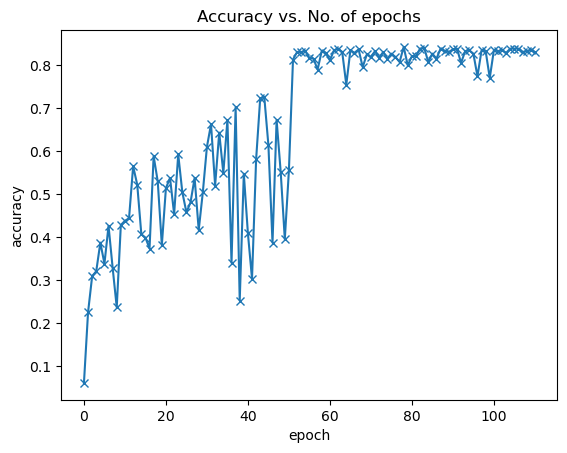

In [26]:
plot_accuracies(history)

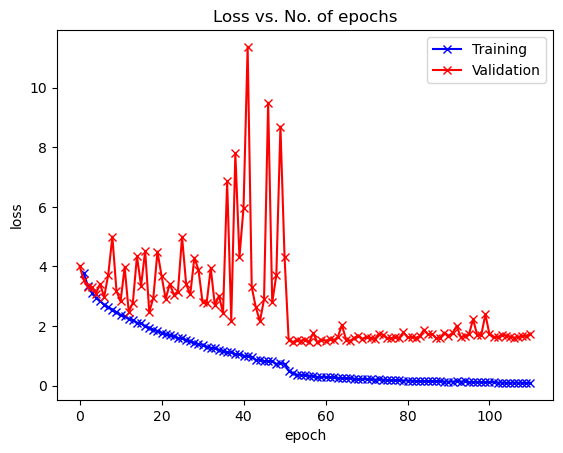

In [27]:
plot_losses(history)

In [28]:
evaluate(model, test_loader)

{'val_loss': 1.5192835330963135, 'val_acc': 0.831250011920929}

In [ ]:
torch.save(model, 'entire_model.pth')